# Used Car Estimator
## A Big Data project using Craigslist Used Car Dataset to build a data science pipeline using Spark
#### By Eve Sheridan

# Table of Contents <a class="anchor" name="table-of-contents"></a>

* [1. Introduction](#introduction)
* [2. Spark Configuration](#spark-config)
* [3. Phase2 - Cleaning and Reshaping](#phase2)
* [4. Phase3 - Develop Machine Learning Pipeline](#phase3)
    * [4.1 Data Loading and scaling](#data-loading-scale)
        * [4.1.1 Data Loading](#dataload)    
        * [4.1.2 Check Null Values](#nulls)  
        * [4.1.3 Scale Numeric Variables](#scaling)  
    * [4.2 Model 1 - Develop Simple Model](#mod1)
        * [4.2.1 Data Preparation](#mod1-dataprep)
        * [4.2.2 Train-Test Split](#mod1-train-test-split)
        * [4.2.3 Model Building](#mod1-model-building)
        * [4.2.4 Evaluation](#mod1-evaluation)
            * [4.2.4.1 Root Mean Square Error (RMSE)](#mod1-rmse)
            * [4.2.4.2 R squared Error (R2)](#mod1-r2)
            * [4.2.4.3 Plot Results](#mod1-plot)
    * [4.3 Model 2 - Develop Simple Model (using scaled attributes)](#mod2)
        * [4.3.1 Data Preparation](#mod2-dataprep)
        * [4.3.2 Train-Test Split](#mod2-train-test-split)
        * [4.3.3 Model Building](#mod2-model-building)
        * [4.3.4 Evaluation](#mod2-evaluation)
            * [4.3.4.1 Root Mean Square Error (RMSE)](#mod2-rmse)
            * [4.3.4.2 R squared Error (R2)](#mod2-r2)    
            * [4.3.4.3 Plot Results](#mod2-plot)            
    * [4.4 Model 3 - Develop More Complex Model (maximising rows)](#mod3)
        * [4.4.1 Data Preparation](#mod3-dataprep)
        * [4.4.2 Train-Test Split](#mod3-train-test-split)
        * [4.4.3 Model Building](#mod3-model-building)
        * [4.4.4 Evaluation](#mod3-evaluation)
            * [4.4.4.1 Root Mean Square Error (RMSE)](#mod3-rmse)
            * [4.4.4.2 R squared Error (R2)](#mod3-r2)  
            * [4.4.4.3 Plot Results](#mod3-plot)               
    * [4.5 Model 4 - Develop More Complex Model (maximising attributes)](#mod4)
        * [4.5.1 Data Preparation](#mod4-dataprep)
        * [4.5.2 Train-Test Split](#mod4-train-test-split)
        * [4.5.3 Model Building](#mod4-model-building)
        * [4.5.4 Evaluation](#mod4-evaluation)
            * [4.5.4.1 Root Mean Square Error (RMSE)](#mod4-rmse)
            * [4.5.4.2 R squared Error (R2)](#mod4-r2) 
            * [4.5.4.3 Plot Results](#mod4-plot)                 
    * [4.6 Best Model Selection](#best-mod)
        * [4.6.1 Setup the model](#best-mod-setup)
        * [4.6.2 Cross Validation & Hyperparameter Tuning](#bestmod-crossval)
        * [4.6.3 Choosing the Best Model](#bestmod-choose)
        * [4.6.4 Making Predictions](#bestmod-pred)
* [5. Conclusion](#conclusion)
* [6. References](#references)



# 1. Introduction <a class="anchor" name="introduction"></a>

This project aims to build a real-world data science pipeline using Spark and is based on the Craigslist Used Car Dataset. The original file is named 'vehilces.csv' and contained 426880 records and 26 attributes.


NOTE: In order to more easily navigate this Jupyter notebook, at the end of each section you can <font color=black>return to the [Table of Contents](#table-of-contents)</font> by clicking the link.

# 2. Spark Configuration <a class="anchor" name="spark-config"></a>

All of the required libraries are imported and spark configuration is completed in the cell below.

In [1]:
#Import all the required libraries
from pyspark import SparkContext, SparkConf

from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import StructType, StringType, IntegerType, FloatType
from pyspark.sql.functions import log, col, exp, round, avg, isnan, when, count

from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler, OneHotEncoder, StringIndexer, MinMaxScaler
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

#plotting
import matplotlib.pyplot as plt

#Spark configuration
master = "local[*]"
app_name = "SparkSQLAssessmentApp"

# Setup configuration parameters for Spark
spark_conf = SparkConf().setMaster(master).setAppName(app_name)
sc = SparkContext.getOrCreate(spark_conf)
sc.setLogLevel('ERROR')
sqlContext = SQLContext(sc)

# Create a SparkSession
spark = (SparkSession
.builder
.appName("SparkSQLAssessmentApp")
.getOrCreate())

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

# 3. Phase 2 - Cleaning and Reshaping <a class="anchor" name="phase2"></a>

If you already have a copy of the vehiclesclean2.csv and wish to skip this section please go directly to section 4. [Phase3 - Develop Machine Learning Pipeline](#phase3)

In [2]:
#Create a custom schema to import the file. 
schema =  StructType() \
    .add("id", StringType(),True) \
    .add("url", StringType(),True) \
    .add("region", StringType(),True) \
    .add("region_url", StringType(),True) \
    .add("price", IntegerType(),True) \
    .add("year", StringType(),True) \
    .add("manufacturer", StringType(),True) \
    .add("model", StringType(),True) \
    .add("condition", StringType(),True) \
    .add("cylinders", StringType(),True) \
    .add("fuel", StringType(),True) \
    .add("odometer", FloatType(),True) \
    .add("title_status", StringType(),True) \
    .add("transmission", StringType(),True) \
    .add("VIN", StringType(),True) \
    .add("drive", StringType(),True) \
    .add("size", StringType(),True) \
    .add("type", StringType(),True) \
    .add("paint_color", StringType(),True) \
    .add("image_url", StringType(),True) \
    .add("description", StringType(),True) \
    .add("county", StringType(),True) \
    .add("state", StringType(),True) \
    .add("lat", FloatType(),True) \
    .add("long", StringType(),True) \
    .add("date", StringType(),True) 

In [3]:
#Import the file. 
vehicles = spark.read.format('csv')\
            .option('header',True)\
            .option('multiline',True)\
            .option('escape','"')\
            .option("delimiter", ",")\
            .schema(schema) \
            .load('vehicles.csv')

# Create Views from Dataframes
vehicles.createOrReplaceTempView("sql_vehicles")
#Check the schema
vehicles.printSchema()

root
 |-- id: string (nullable = true)
 |-- url: string (nullable = true)
 |-- region: string (nullable = true)
 |-- region_url: string (nullable = true)
 |-- price: integer (nullable = true)
 |-- year: string (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: string (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: float (nullable = true)
 |-- title_status: string (nullable = true)
 |-- transmission: string (nullable = true)
 |-- VIN: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- size: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- image_url: string (nullable = true)
 |-- description: string (nullable = true)
 |-- county: string (nullable = true)
 |-- state: string (nullable = true)
 |-- lat: float (nullable = true)
 |-- long: string (nullable = true)
 |-- date: string (nullable = 

In [4]:
# Use SQL to select relevant columns and do initial conversions
# Use the DISTINCT syntax to remove any complete duplicates
# Capitalise all string fields
# extract cylinders and integer
# convert the posted_date and round to date rather than datetime. 
# Description field has been left in for use in imputing missing values 

vehicles = spark.sql('''
  SELECT DISTINCT
        ID,
        upper(region) as region, 
        price,
        year,
        upper(manufacturer) as manufacturer,
        upper(model) as model,
        upper(condition) as condition,
        cast(left(cylinders,2) as int) as cylinders,
        upper(fuel) as fuel,
        odometer,
        upper(title_status) as title_status,
        upper(transmission) as transmission,
        upper(drive) as drive, 
        upper(size) as size,
        upper(type) as type,
        upper(paint_color) as paint_color,
        upper(county) as county,
        upper(state) as state,
        lat,
        long,
        cast(left(date,10) as date) as date,
        upper(description) as description
        
  FROM sql_vehicles
''')
#Create new temp view with types and caps updated for next steps
vehicles.createOrReplaceTempView("sql_vehicles")

In [5]:
#Delete any records that are not 'CLEAN'
vehicles = spark.sql('''
  SELECT *
    FROM sql_vehicles
    WHERE title_status = "CLEAN"
''')

vehicles.createOrReplaceTempView("sql_vehicles")

In [6]:
#Delete any records that are  type 'TRUCK' or 'BUS'
vehicles = spark.sql('''
  SELECT *
    FROM sql_vehicles
    WHERE type <> "TRUCK" AND type <> "BUS"
''')
vehicles.createOrReplaceTempView("sql_vehicles")

In [7]:
#Delete any records that don't have a fuel type
vehicles = spark.sql('''
  SELECT *
    FROM sql_vehicles
    WHERE fuel is not null
''')
vehicles.createOrReplaceTempView("sql_vehicles")

In [8]:
#Delete any records that have null transmission
vehicles = spark.sql('''
  SELECT *
    FROM sql_vehicles
    WHERE transmission is not null
''')
vehicles.createOrReplaceTempView("sql_vehicles")

In [9]:
#Delete any records that have price = 0 or null
vehicles = spark.sql('''
  SELECT *
    FROM sql_vehicles
    WHERE price is not null and price > 0
''')
vehicles.createOrReplaceTempView("sql_vehicles")

In [10]:
#Select columns and extract year from description if it exists
vehicles = spark.sql('''
  SELECT id,
        region,
        price,
        coalesce(cast(cast(year as int) as string), 
                cast(cast(left(description,4) as int) as string), 
                cast(cast(SUBSTR(description, POSITION(description, 'YEAR: ')+6, 4) as int) as string)) 
                as year,
        manufacturer,
        model,
        condition,
        cylinders,
        fuel,
        odometer,
        title_status,
        transmission,
        drive,
        size,
        type,
        paint_color,
        county,
        state,
        lat,
        long,
        date,
        description

    FROM sql_vehicles
''')
vehicles.createOrReplaceTempView("sql_vehicles")

In [11]:
#Delete any remaining records with null year
vehicles = spark.sql('''
  SELECT *
    FROM sql_vehicles
    WHERE year is not null
''')
vehicles.createOrReplaceTempView("sql_vehicles")

In [12]:
# Delete any records with null manufacturer
vehicles = spark.sql('''
  SELECT *
    from sql_vehicles r
    WHERE manufacturer is not null and manufacturer<> ''
''')
vehicles.createOrReplaceTempView("sql_vehicles")

In [13]:
# Delete any records with null model
vehicles = spark.sql('''
  SELECT *
    from sql_vehicles r
    WHERE model is not null and model <> ''
''')
vehicles.createOrReplaceTempView("sql_vehicles")

In [14]:
# Exclude price outliers: > 90,000 and < 1000
vehicles = spark.sql('''
  SELECT *
    FROM sql_vehicles
    WHERE price < 90000 and price > 1000
''')
vehicles.createOrReplaceTempView("sql_vehicles")

In [15]:
#Create a new field 'pricelog' to use as label in machine learning model
vehicles = vehicles.withColumn("pricelog", log("price"))
vehicles.createOrReplaceTempView("sql_vehicles")

In [16]:
# Exclude year outliers: < 1995 and > 2020
vehicles = spark.sql('''
  SELECT *
    FROM sql_vehicles
    WHERE int(year) > 1995 AND int(year) < 2020
''')
vehicles.createOrReplaceTempView("sql_vehicles")

In [17]:
# Exclude odo outliers: > 300000 and < 500
vehicles = spark.sql('''
  SELECT *
    FROM sql_vehicles
    WHERE odometer < 300000 and odometer > 500
''')
vehicles.createOrReplaceTempView("sql_vehicles")

In [18]:
#Select required attributes and transform year to int
vehicles = spark.sql('''
  SELECT 
        id,
        price,
        pricelog,
        CAST(year as int),
        manufacturer,
        model,
        condition,
        cylinders,
        fuel,
        odometer,
        transmission,
        drive, 
        type,
        paint_color,
        state        
  FROM sql_vehicles
''')
#Create new temp view
vehicles.createOrReplaceTempView("sql_vehicles")

In [19]:
#check size of final file
print((vehicles.count(), len(vehicles.columns)))

(218927, 15)


In [20]:
#Export final file
vehicles.repartition(1).write.format("com.databricks.spark.csv").option("header", "true").save("vehiclesclean2.csv")

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

# 4. Phase 3 - Develop Machine Learning Pipeline <a class="anchor" name="phase3"></a>

A supervised machine learning model (Linear Regression) will be developed using this dataset with Price as the label with the goal of predicting the price given a new unlabeled input.  

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

## 4.1 Data Loading and scaling <a class="anchor" name="data-loading-scale"></a>

### 4.1.1 Data Loading <a class="anchor" name="dataload"></a>

Please use the file ‘vehilcesclean2.csv’ for this section.

In this section, the data file will be loaded, null values will be checked and the numeric columns year and odometer will be scaled.

In [21]:
#Read in the file
vehicles = spark.read.csv('vehiclesclean2.csv', header = True, inferSchema = True)

#Get column names
cols = vehicles.columns

In [22]:
#Check the schema
vehicles.printSchema()

root
 |-- id: long (nullable = true)
 |-- price: integer (nullable = true)
 |-- pricelog: double (nullable = true)
 |-- year: integer (nullable = true)
 |-- manufacturer: string (nullable = true)
 |-- model: string (nullable = true)
 |-- condition: string (nullable = true)
 |-- cylinders: integer (nullable = true)
 |-- fuel: string (nullable = true)
 |-- odometer: double (nullable = true)
 |-- transmission: string (nullable = true)
 |-- drive: string (nullable = true)
 |-- type: string (nullable = true)
 |-- paint_color: string (nullable = true)
 |-- state: string (nullable = true)



<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### 4.1.2 Check null values <a class="anchor" name="nulls"></a>

In [23]:
#check null values for each attribute that will need to be removed before inclusion in a ML model
vehicles.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in vehicles.columns]
   ).show()

+---+-----+--------+----+------------+-----+---------+---------+----+--------+------------+-----+----+-----------+-----+
| id|price|pricelog|year|manufacturer|model|condition|cylinders|fuel|odometer|transmission|drive|type|paint_color|state|
+---+-----+--------+----+------------+-----+---------+---------+----+--------+------------+-----+----+-----------+-----+
|  0|    0|       0|   0|           0|    0|    69308|    77544|   0|       0|           0|47917|   0|      36138|    0|
+---+-----+--------+----+------------+-----+---------+---------+----+--------+------------+-----+----+-----------+-----+



Note the large number of null values that will be need to be removed when using attributes condition, cylinders, drive and paint_color.

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### 4.1.3 Scale Numeric Values <a class="anchor" name="scaling"></a>

Feature Scaling is a technique to standardize the independent features present in the data in a fixed range. If feature scaling is not done, then a machine learning algorithm tends to weigh greater values, higher and consider smaller values as the lower values, regardless of the unit of the values.  The numeric columns year and odometer will be scaled to avoid these problems in the linear regression model.
NOTE: cylinders was not scaled because of the large number of null values present.

In [24]:
#Scale Numeric Values
#define the numeric columns for scaling
numericCols = ['year', 'odometer']

#Create vector columns for input to scaler
assemblers = [VectorAssembler(inputCols=[col], outputCol=col + "_vec") for col in numericCols]

#Define scaler on selected columns
scalers = [MinMaxScaler(inputCol=col + "_vec", outputCol=col + "_scaled") for col in numericCols]

#assemble into pipeline
pipeline = Pipeline(stages=assemblers + scalers)

#setup model
scalerModel = pipeline.fit(vehicles)

#apply transformation
scaledData = scalerModel.transform(vehicles)

#Check
scaledData.show(3)

#Update view
scaledData.createOrReplaceTempView("sql_vehicles")

+----------+-----+-----------------+----+------------+------------+---------+---------+-----+--------+------------+-----+-----+-----------+-----+--------+------------+--------------------+--------------------+
|        id|price|         pricelog|year|manufacturer|       model|condition|cylinders| fuel|odometer|transmission|drive| type|paint_color|state|year_vec|odometer_vec|         year_scaled|     odometer_scaled|
+----------+-----+-----------------+----+------------+------------+---------+---------+-----+--------+------------+-----+-----+-----------+-----+--------+------------+--------------------+--------------------+
|7301593334| 8995|9.104424146384634|2013|        FORD|EXPLORER 4X4|     GOOD|        6|  GAS|150000.0|   AUTOMATIC|  4WD|  SUV|     CUSTOM|   CT|[2013.0]|  [150000.0]|[0.7391304347826086]|[0.4991652698849408]|
|7301621162|10000|9.210340371976184|2010|      TOYOTA|        RAV4| LIKE NEW|        4|  GAS|105000.0|   AUTOMATIC| null|  SUV|       GREY|   DE|[2010.0]|  [105

In [25]:
#Select required attributes for vehicles file
vehicles = spark.sql('''
  SELECT 
        id,
        price,
        pricelog,
        year,
        year_vec,
        year_scaled,
        manufacturer,
        model,
        condition,
        cylinders,
        fuel,
        odometer,
        odometer_vec,
        odometer_scaled,
        transmission,
        drive, 
        type,
        paint_color,
        state        
  FROM sql_vehicles
''')
#Create new temp view
vehicles.createOrReplaceTempView("sql_vehicles")

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

## <font color='blue'>4.2 Model 1 - Develop Simple Model <a class="anchor" name="mod1"></a></font>


Model 1 is first attempt at creating a simple regression model using only year, manufacturer and odometer.  Default hyperparameters will be used so no hyperparameter tuning will be carried out on model 1.

NOTE: year_scaled and odometer_scaled will be used in the next model (Model 2) to compare if having these attributes scaled makes a difference.

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='blue'>4.2.1 Data Preparation <a class="anchor" name="mod1-dataprep"></a></font>


In [26]:
#Select required attributes for mod1 and take a look
mod1 = vehicles.select("pricelog", "year", "manufacturer", "odometer")
mod1.show(5)

+------------------+----+------------+--------+
|          pricelog|year|manufacturer|odometer|
+------------------+----+------------+--------+
| 9.104424146384634|2013|        FORD|150000.0|
| 9.210340371976184|2010|      TOYOTA|105000.0|
| 8.852950887099581|2008|      TOYOTA|183205.0|
| 10.36059589379613|2018|  ALFA-ROMEO| 21415.0|
|10.085767441795337|2014|   CHEVROLET| 94860.0|
+------------------+----+------------+--------+
only showing top 5 rows



<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='blue'>4.2.2 Train-Test Split <a class="anchor" name="mod1-train-test-split"></a></font>


Split the data into train and test sets

In [27]:
#Split the data and check the row numbers
trainDF, testDF = mod1.randomSplit([.8, .2], seed=42)
print(f"""There are {trainDF.count()} rows in the training set, 
and {testDF.count()} in the test set""")


There are 175126 rows in the training set, 
and 43801 in the test set


<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='blue'>4.2.3 Model Building <a class="anchor" name="mod1-model-building"></a></font>


First transform the data into a single vector using VectorAssembler which takes a list of input columns and creates a new dataframe with an additional column, called features.  VectorAssembler combines the values of those input columns into a single vector.

The categorical values need to be first mapped into numeric values by applying StringIndexer (which converts categorical values into category indexes) then pass these inputs to the OneHotEncoder which maps a column of category indices to a column of binary vectors.

In [28]:
#Define the categorical and numeric columns
categoricalCols = ['manufacturer']
numericCols = ['year', 'odometer']

#Define column names for index output columns and ohe output
indexOutputCols = [x + "Index" for x in categoricalCols]
oheOutputCols = [x + "OHE" for x in categoricalCols]

#apply string indexer and ohe
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=indexOutputCols, handleInvalid="skip")
oheEncoder = OneHotEncoder(inputCols=indexOutputCols, outputCols=oheOutputCols)

#Define the vector assembler inputs (ohe and numeric columns)
assemblerInputs = oheOutputCols + numericCols

#Run the vector assembler
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In order to apply our model to our test set, need to prepare the test data in the same way as the training set so setup the stages in a pipeline.

In [29]:
#Define the linear regression
lr = LinearRegression(labelCol="pricelog", featuresCol="features")

#build the pipeline
pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, lr])

#apply the pipeline to the training dataset
pipelineModel = pipeline.fit(trainDF)

#apply the pipeline to the test dataset
predDF = pipelineModel.transform(testDF)

#take a sample and look
predDF.select("features", "pricelog", "prediction").show(5)

+--------------------+-----------------+------------------+
|            features|         pricelog|        prediction|
+--------------------+-----------------+------------------+
|(41,[8,39,40],[1....|6.957497370876951|10.383523316827535|
|(41,[3,39,40],[1....|7.003065458786462|7.6731590115179245|
|(41,[15,39,40],[1...|7.003065458786462| 8.233746201941528|
|(41,[5,39,40],[1....|7.003065458786462| 8.071574051574174|
|(41,[1,39,40],[1....|7.003065458786462| 8.281197919979633|
+--------------------+-----------------+------------------+
only showing top 5 rows



The features column is represented as a SparseVector. There are 41
features after one-hot encoding, followed by the nonzero indices and then the values
themselves.

In [30]:
#Take a look at the other columns
predDF.select("features", "year", "manufacturer", "odometer", "pricelog", "prediction").show(5)

+--------------------+----+-------------+--------+-----------------+------------------+
|            features|year| manufacturer|odometer|         pricelog|        prediction|
+--------------------+----+-------------+--------+-----------------+------------------+
|(41,[8,39,40],[1....|2016|MERCEDES-BENZ| 17046.0|6.957497370876951|10.383523316827535|
|(41,[3,39,40],[1....|1997|        HONDA|217005.0|7.003065458786462|7.6731590115179245|
|(41,[15,39,40],[1...|1999|         AUDI|195000.0|7.003065458786462| 8.233746201941528|
|(41,[5,39,40],[1....|2002|       NISSAN|181180.0|7.003065458786462| 8.071574051574174|
|(41,[1,39,40],[1....|2003|    CHEVROLET|234000.0|7.003065458786462| 8.281197919979633|
+--------------------+----+-------------+--------+-----------------+------------------+
only showing top 5 rows



To compare actual price instead of log price convert back to real price

In [31]:
check = predDF.withColumn("price", exp("pricelog")).withColumn("predprice", exp("prediction"))
check.select("year", "manufacturer", "odometer", round("price"), round("predprice")).show(15)


+----+-------------+--------+---------------+-------------------+
|year| manufacturer|odometer|round(price, 0)|round(predprice, 0)|
+----+-------------+--------+---------------+-------------------+
|2016|MERCEDES-BENZ| 17046.0|         1051.0|            32323.0|
|1997|        HONDA|217005.0|         1100.0|             2150.0|
|1999|         AUDI|195000.0|         1100.0|             3766.0|
|2002|       NISSAN|181180.0|         1100.0|             3202.0|
|2003|    CHEVROLET|234000.0|         1100.0|             3949.0|
|2004|   MITSUBISHI|170000.0|         1100.0|             3507.0|
|2008|       SATURN|126000.0|         1100.0|             5275.0|
|2005|       NISSAN|172872.0|         1150.0|             4136.0|
|1996|         FORD|197000.0|         1200.0|             2878.0|
|1996|      PONTIAC|110000.0|         1200.0|             2849.0|
|1996|       SATURN|200000.0|         1200.0|             1563.0|
|1997|    CHEVROLET|200000.0|         1200.0|             3005.0|
|1997|    

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='blue'>4.2.4 Evaluation <a class="anchor" name="mod1-evaluation"></a></font>

Root Mean Square Error (RMSE) and R squared (R2) will be used to evaluate the model performance.

#### <font color='blue'>4.2.4.1 Root Mean Square Error (RMSE) <a class="anchor" name="mod1-rmse"></a></font>

RMSE is a metric that ranges from zero to infinity.  The closer it is to zero the better.

In [32]:
#Evaluate the model using RMSE
regressionEvaluator = RegressionEvaluator(
 predictionCol="prediction",
 labelCol="pricelog",
 metricName="rmse")
mod1rmse = regressionEvaluator.evaluate(predDF)
print(f"Model 1 RMSE is {mod1rmse:.5f}")


Model 1 RMSE is 0.44037


In order to interpret this value we need to build a simple baseline model and compute its RMSE to compare against. 
A very simple yet natural baseline model is one where we always make the same prediction independent of the given data point, using the average label in the training set as the constant prediction value. The average logprice for the training set first needs to be calculated.

In [33]:
#compute the average pricelog for the training dataset
mod1avg = trainDF.select(avg("pricelog")).collect()[0][0]
print(f"Average pricelog for training dataset is {mod1avg:.5f}")

Average pricelog for training dataset is 9.58274


Now need to see how well this naive baseline performs. First implement a function to compute RMSE given an RDD of (label, prediction) tuples (databricks, n.d.).

In [34]:
#Create a function to calculate the RMSE for an RDD of (label, prediction) tuples
def squaredError(label, prediction):
    """Calculates the squared error for a single prediction.

    Args:
        label (float): The correct value for this observation.
        prediction (float): The predicted value for this observation.

    Returns:
        float: The difference between the `label` and `prediction` squared.
    """
    return (prediction-label)**2

def calcRMSE(labelsAndPreds):
    from math import sqrt
    """Calculates the root mean squared error for an `RDD` of (label, prediction) tuples.

    Args:
        labelsAndPred (RDD of (float, float)): An `RDD` consisting of (label, prediction) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    return sqrt(labelsAndPreds.map(lambda x: squaredError(*x)).mean())


Now calculate the training and test RMSE of our baseline model. To do this, first create RDDs of (label, prediction) tuples for each dataset, and then call calcRMSE. Note that each RMSE can be interpreted as the average prediction error for the given dataset (in terms of price).

In [35]:
#First convert Pyspark dataframes to RDDs
trainrdd=trainDF.rdd
testrdd=testDF.rdd

#create RDDs of (label, prediction) tuples for training dataset
labelsAndPredsTrain = trainrdd.map(lambda x: (x.pricelog, mod1avg))

#call calcRMSE
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

#create RDDs of (label, prediction) tuples for test dataset
labelsAndPredsTest = testrdd.map(lambda x: (x.pricelog, mod1avg))

##call calcRMSE
rmseTestBase = calcRMSE(labelsAndPredsTest)

print('Baseline Train RMSE = {0:.5f}'.format(rmseTrainBase))
print('Baseline Test RMSE = {0:.5f}'.format(rmseTestBase))
print("Compare this with...")
print(f"Model 1 RMSE = {mod1rmse:.5f}")

Baseline Train RMSE = 0.77300
Baseline Test RMSE = 0.76532
Compare this with...
Model 1 RMSE = 0.44037


Our model (RSME = 0.440) beat the baseline of 0.773 so yay!

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

#### <font color='blue'>4.2.4.2 R squared (R2) Error <a class="anchor" name="mod1-r2"></a></font>

Another option for evaluating the model is to use R2.

In [36]:
# Evaluate using R2
mod1r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"Model 1 R2 is {mod1r2:.5f}")


Model 1 R2 is 0.66890


If the model perfectly predicts every point it would have an R2 values of 1 and a model that is not performing well has a value closer to 0.  This model has an R2 value = 0.67

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

#### <font color='blue'>4.2.4.3 Plot results<a class="anchor" name="mod1-plot"></a></font>

<AxesSubplot:title={'center':'Model 1: Predicted Price vs Price'}, xlabel='price', ylabel='predprice'>

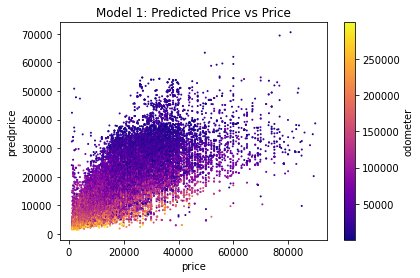

In [37]:
#Create a pandas dataframe for plotting
df = check.select("price", "predprice", "odometer").toPandas()

#Plot predprice vs price on a scatter graph
fig, ax = plt.subplots()
plt.title('Model 1: Predicted Price vs Price')
df.plot(kind="scatter", x="price", y="predprice", s=1, c="odometer", cmap="plasma", ax=ax)

A perfect model would be a perfectly straight line.  This model has quite a large spread in points.

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

## <font color='green'>4.3 Model 2 - Develop Simple Model using scaled variables <a class="anchor" name="mod2"></a></font>


Model 2 is second attempt at creating a simple regression model this time using the scaled numeric values (year_scaled, and odometer_scaled).  Default hyperparameters will be used so no hyperparameter tuning will be carried out on model 2.

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='green'>4.3.1 Data Preparation <a class="anchor" name="mod2-dataprep"></a></font>

In [38]:
#Select required attributes for mod2 and take a look
mod2 = vehicles.select("pricelog", "year", "year_scaled", "manufacturer", "odometer", "odometer_scaled")
mod2.show(5)

+------------------+----+--------------------+------------+--------+--------------------+
|          pricelog|year|         year_scaled|manufacturer|odometer|     odometer_scaled|
+------------------+----+--------------------+------------+--------+--------------------+
| 9.104424146384634|2013|[0.7391304347826086]|        FORD|150000.0|[0.4991652698849408]|
| 9.210340371976184|2010|[0.6086956521739131]|      TOYOTA|105000.0| [0.348913849174285]|
| 8.852950887099581|2008|[0.5217391304347826]|      TOYOTA|183205.0|[0.6100341237671036]|
| 10.36059589379613|2018|[0.9565217391304348]|  ALFA-ROMEO| 21415.0|[0.06983018250539...|
|10.085767441795337|2014|[0.7826086956521738]|   CHEVROLET| 94860.0|[0.31505719570748...|
+------------------+----+--------------------+------------+--------+--------------------+
only showing top 5 rows



<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='green'>4.3.2 Train-Test Split <a class="anchor" name="mod2-train-test-split"></a></font>

Split the data into train and test sets

In [39]:
#Split the data and check the row numbers
trainDF, testDF = mod2.randomSplit([.8, .2], seed=42)
print(f"""There are {trainDF.count()} rows in the training set, 
and {testDF.count()} in the test set""")


There are 175126 rows in the training set, 
and 43801 in the test set


<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='green'>4.3.3 Model Building <a class="anchor" name="mod2-model-building"></a></font>

First transform the data into a single vector using VectorAssembler which takes a list of input columns and creates a new dataframe with an additional column, called features.  VectorAssembler combines the values of those input columns into a single vector.

The categorical values need to be first mapped into numeric values by applying StringIndexer (which converts categorical values into category indexes) then pass these inputs to the OneHotEncoder which maps a column of category indices to a column of binary vectors.

In [40]:
#Define the categorical and numeric columns
categoricalCols = ['manufacturer']
numericCols = ['year_scaled', 'odometer_scaled']

#Define column names for index output columns and ohe output
indexOutputCols = [x + "Index" for x in categoricalCols]
oheOutputCols = [x + "OHE" for x in categoricalCols]

#apply string indexer and ohe
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=indexOutputCols, handleInvalid="skip")
oheEncoder = OneHotEncoder(inputCols=indexOutputCols, outputCols=oheOutputCols)

#Define the vector assembler inputs (ohe and numeric columns)
assemblerInputs = oheOutputCols + numericCols

#Run the vector assembler
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In order to apply our model to our test set, need to prepare the test data in the same way as the training set so setup the stages in a pipeline.

In [41]:
#Define the linear regression
lr = LinearRegression(labelCol="pricelog", featuresCol="features")

#build the pipeline
pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, lr])

#apply the pipeline to the training dataset
pipelineModel = pipeline.fit(trainDF)

#apply the pipeline to the test dataset
predDF = pipelineModel.transform(testDF)

#take a sample and look
predDF.select("features", "pricelog", "prediction").show(5)

+--------------------+-----------------+------------------+
|            features|         pricelog|        prediction|
+--------------------+-----------------+------------------+
|(41,[8,39,40],[1....|6.957497370876951|10.383523316826683|
|(41,[3,39,40],[1....|7.003065458786462| 7.673159011553483|
|(41,[15,39,40],[1...|7.003065458786462| 8.233746201976851|
|(41,[5,39,40],[1....|7.003065458786462| 8.071574051601024|
|(41,[1,39,40],[1....|7.003065458786462| 8.281197919985381|
+--------------------+-----------------+------------------+
only showing top 5 rows



The features column is represented as a SparseVector. There are 41
features after one-hot encoding, followed by the nonzero indices and then the values
themselves.

In [42]:
#Take a look at the other columns
predDF.select("features", "year", "year_scaled", "manufacturer", "odometer_scaled", "pricelog", "prediction").show(5)

+--------------------+----+--------------------+-------------+--------------------+-----------------+------------------+
|            features|year|         year_scaled| manufacturer|     odometer_scaled|         pricelog|        prediction|
+--------------------+----+--------------------+-------------+--------------------+-----------------+------------------+
|(41,[8,39,40],[1....|2016|[0.8695652173913043]|MERCEDES-BENZ|[0.05524243901461...|6.957497370876951|10.383523316826683|
|(41,[3,39,40],[1....|1997|[0.04347826086956...|        HONDA|[0.7228896353231073]|7.003065458786462| 7.673159011553483|
|(41,[15,39,40],[1...|1999|[0.13043478260869...|         AUDI|[0.6494166905955966]|7.003065458786462| 8.233746201976851|
|(41,[5,39,40],[1....|2002|[0.2608695652173913]|       NISSAN|[0.6032728098351241]|7.003065458786462| 8.071574051601024|
|(41,[1,39,40],[1....|2003|[0.30434782608695...|    CHEVROLET|[0.7796345885448317]|7.003065458786462| 8.281197919985381|
+--------------------+----+-----

To compare actual price instead of log price convert back to real price

In [43]:
check = predDF.withColumn("price", exp("pricelog")).withColumn("predprice", exp("prediction"))
check.select("year", "year_scaled", "manufacturer", "odometer", "odometer_scaled", round("price"), round("predprice")).show(15)


+----+--------------------+-------------+--------+--------------------+---------------+-------------------+
|year|         year_scaled| manufacturer|odometer|     odometer_scaled|round(price, 0)|round(predprice, 0)|
+----+--------------------+-------------+--------+--------------------+---------------+-------------------+
|2016|[0.8695652173913043]|MERCEDES-BENZ| 17046.0|[0.05524243901461...|         1051.0|            32323.0|
|1997|[0.04347826086956...|        HONDA|217005.0|[0.7228896353231073]|         1100.0|             2150.0|
|1999|[0.13043478260869...|         AUDI|195000.0|[0.6494166905955966]|         1100.0|             3766.0|
|2002|[0.2608695652173913]|       NISSAN|181180.0|[0.6032728098351241]|         1100.0|             3202.0|
|2003|[0.30434782608695...|    CHEVROLET|234000.0|[0.7796345885448317]|         1100.0|             3949.0|
|2004|[0.34782608695652...|   MITSUBISHI|170000.0|[0.5659436790896767]|         1100.0|             3507.0|
|2008|[0.5217391304347826]| 

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='green'>4.3.4 Evaluation <a class="anchor" name="mod2-evaluation"></a></font>

Root Mean Square Error (RMSE) and R squared (R2) will be used to evaluate the model performance.

#### <font color='green'>4.3.4.1 Root Mean Square Error (RMSE) <a class="anchor" name="mod2-rmse"></a></font>

RMSE is a metric that ranges from zero to infinity.  The closer it is to zero the better.

In [44]:
#Evaluate the model using RMSE
regressionEvaluator = RegressionEvaluator(
 predictionCol="prediction",
 labelCol="pricelog",
 metricName="rmse")
mod2rmse = regressionEvaluator.evaluate(predDF)
print(f"Model 2 RMSE is {mod2rmse:.5f}")
print("Compare this with...")
print(f"Model 1 RMSE is {mod1rmse:.5f}")


Model 2 RMSE is 0.44037
Compare this with...
Model 1 RMSE is 0.44037


Check performance by creating simple baseline model using average pricelog.

In [45]:
#compute the average pricelog for the training dataset
mod2avg = trainDF.select(avg("pricelog")).collect()[0][0]
print(f"Average pricelog for training dataset is {mod2avg:.5f}")
      

Average pricelog for training dataset is 9.58274


See how well this naive baseline performs.  Calculate the training and test RMSE of our baseline model. To do this, first create RDDs of (label, prediction) tuples for each dataset, and then call calcRMSE. Note that each RMSE can be interpreted as the average prediction error for the given dataset (in terms of price).

In [46]:
#First convert Pyspark dataframes to RDDs
trainrdd=trainDF.rdd
testrdd=testDF.rdd

#create RDDs of (label, prediction) tuples for training dataset
labelsAndPredsTrain = trainrdd.map(lambda x: (x.pricelog, mod2avg))

#call calcRMSE
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

#create RDDs of (label, prediction) tuples for test dataset
labelsAndPredsTest = testrdd.map(lambda x: (x.pricelog, mod2avg))

##call calcRMSE
rmseTestBase = calcRMSE(labelsAndPredsTest)

print('Baseline Train RMSE = {0:.5f}'.format(rmseTrainBase))
print('Baseline Test RMSE = {0:.5f}'.format(rmseTestBase))
print("Compare this with...")
print(f"Model 2 RMSE = {mod2rmse:.5f}")
print("and...")
print(f"Model 1 RMSE = {mod1rmse:.5f}")

Baseline Train RMSE = 0.77300
Baseline Test RMSE = 0.76532
Compare this with...
Model 2 RMSE = 0.44037
and...
Model 1 RMSE = 0.44037


Our model (RSME = 0.440) beat the baseline of 0.773 so yay!

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

#### <font color='green'>4.3.4.2 R Squared Error (R2) <a class="anchor" name="mod2-r2"></a></font>

Another option for evaluating the model is to use R2.

In [47]:
# Evaluate using R2
mod2r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"Model 2 R2 is {mod2r2:.5f}")
print("Compare this with..")
print(f"Model 1 R2 is {mod1r2:.5f}")


Model 2 R2 is 0.66890
Compare this with..
Model 1 R2 is 0.66890


Model 2 is performing better than Model 1 using the scaled variables.

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

#### <font color='green'>4.3.4.3 Plot results<a class="anchor" name="mod2-plot"></a></font>

<AxesSubplot:title={'center':'Model 2: Predicted Price vs Price'}, xlabel='price', ylabel='predprice'>

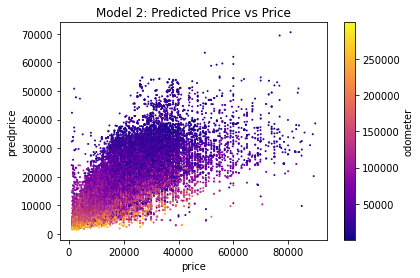

In [48]:
#Create a pandas dataframe for plotting
df = check.select("price", "predprice", "odometer").toPandas()

#Plot predprice vs price on a scatter graph
fig, ax = plt.subplots()
plt.title('Model 2: Predicted Price vs Price')
df.plot(kind="scatter", x="price", y="predprice", s=1, c="odometer", cmap="plasma", ax=ax)

A perfect model would be a perfectly straight line.  This model has quite a large spread in points.

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

## <font color='grey'>4.4 Model 3 - Develop More Complex Model (maximising rows) <a class="anchor" name="mod3"></a></font>


Model 3 is a more complex model using all of the available attributes which do not contain null values.

### <font color='grey'>4.4.1 Data Preparation <a class="anchor" name="mod3-dataprep"></a></font>

In [49]:
#Select required attributes for mod3 and take a look
mod3 = vehicles.select("pricelog", "year", "year_scaled", "manufacturer", "model", "fuel", "odometer", "odometer_scaled", "transmission", "type", "state")
mod3.show(2)

+-----------------+----+--------------------+------------+------------+----+--------+--------------------+------------+----+-----+
|         pricelog|year|         year_scaled|manufacturer|       model|fuel|odometer|     odometer_scaled|transmission|type|state|
+-----------------+----+--------------------+------------+------------+----+--------+--------------------+------------+----+-----+
|9.104424146384634|2013|[0.7391304347826086]|        FORD|EXPLORER 4X4| GAS|150000.0|[0.4991652698849408]|   AUTOMATIC| SUV|   CT|
|9.210340371976184|2010|[0.6086956521739131]|      TOYOTA|        RAV4| GAS|105000.0| [0.348913849174285]|   AUTOMATIC| SUV|   DE|
+-----------------+----+--------------------+------------+------------+----+--------+--------------------+------------+----+-----+
only showing top 2 rows



<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='grey'>4.4.2 Train-Test Split <a class="anchor" name="mod3-train-test-split"></a></font>

In [50]:
#split the data into train and test and check number of rows
trainDF, testDF = mod3.randomSplit([.8, .2], seed=42)
print(f"""There are {trainDF.count()} rows in the training set, 
and {testDF.count()} in the test set""")


There are 175126 rows in the training set, 
and 43801 in the test set


<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='grey'>4.4.3 Model Building <a class="anchor" name="mod3-model-building"></a></font>

First transform the data into a single vector using VectorAssembler which takes a list of input columns and creates a new dataframe with an additional column, called features.  VectorAssembler combines the values of those input columns into a single vector.

The categorical values need to be first mapped into numeric values by applying StringIndexer (which converts categorical values into category indexes) then pass these inputs to the OneHotEncoder which maps a column of category indices to a column of binary vectors.

In [51]:
#Define the categorical and numeric columns
categoricalCols = ['manufacturer', 'model', 'fuel', 'transmission', 'type', 'state']
numericCols = ['year_scaled', 'odometer_scaled']

#Define column names for index output columns and ohe output
indexOutputCols = [x + "Index" for x in categoricalCols]
oheOutputCols = [x + "OHE" for x in categoricalCols]

#apply string indexer and ohe
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=indexOutputCols, handleInvalid="skip")
oheEncoder = OneHotEncoder(inputCols=indexOutputCols, outputCols=oheOutputCols)

#Define the vector assembler inputs (ohe and numeric columns)
assemblerInputs = oheOutputCols + numericCols

#Run the vector assembler
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In order to apply our model to our test set, need to prepare the test data in the same way as the training set so setup the stages in a pipeline.

In [52]:
#Define the linear regression
lr = LinearRegression(labelCol="pricelog", featuresCol="features")

#build the pipeline
pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, lr])

#apply the pipeline to the training dataset
pipelineModel = pipeline.fit(trainDF)

#apply the pipeline to the test dataset
predDF = pipelineModel.transform(testDF)

#take a sample and look
predDF.select("features", "pricelog", "prediction").show(5)

+--------------------+-----------------+-----------------+
|            features|         pricelog|       prediction|
+--------------------+-----------------+-----------------+
|(12258,[3,60,1219...|7.003065458786462| 7.66513328975908|
|(12258,[15,104,12...|7.003065458786462|7.865819222301518|
|(12258,[5,137,121...|7.003065458786462|7.990743085136449|
|(12258,[1,1358,12...|7.003065458786462|7.626881851084705|
|(12258,[26,336,12...|7.003065458786462|8.007075907124197|
+--------------------+-----------------+-----------------+
only showing top 5 rows



The features column is represented as a SparseVector. There are 12258
features after one-hot encoding, followed by the nonzero indices and then the values
themselves.

In [53]:
#Take a look at the other columns
predDF.select("year", "manufacturer", "model", "fuel", "odometer", "transmission", "type", "state", "pricelog", "prediction").show(10)

+----+------------+----------------+----+--------+------------+---------+-----+-----------------+------------------+
|year|manufacturer|           model|fuel|odometer|transmission|     type|state|         pricelog|        prediction|
+----+------------+----------------+----+--------+------------+---------+-----+-----------------+------------------+
|1997|       HONDA|         ODYSSEY| GAS|217005.0|   AUTOMATIC| MINI-VAN|   AZ|7.003065458786462|  7.66513328975908|
|1999|        AUDI|              A4| GAS|195000.0|      MANUAL|    SEDAN|   FL|7.003065458786462| 7.865819222301518|
|2002|      NISSAN|          MAXIMA| GAS|181180.0|   AUTOMATIC|    SEDAN|   MD|7.003065458786462| 7.990743085136449|
|2003|   CHEVROLET|         VENTURE| GAS|234000.0|   AUTOMATIC| MINI-VAN|   OH|7.003065458786462| 7.626881851084705|
|2004|  MITSUBISHI|          LANCER| GAS|170000.0|   AUTOMATIC|    SEDAN|   OH|7.003065458786462| 8.007075907124197|
|2008|      SATURN|            AURA| GAS|126000.0|   AUTOMATIC| 

To compare actual price instead of log price convert back to real price

In [54]:
check = predDF.withColumn("price", exp("pricelog")).withColumn("predprice", exp("prediction"))
check.select("year", "manufacturer", "model", "fuel", "odometer", "transmission", "type", "state", round("price"), round("predprice")).show(20)


+----+------------+----------------+----+--------+------------+---------+-----+---------------+-------------------+
|year|manufacturer|           model|fuel|odometer|transmission|     type|state|round(price, 0)|round(predprice, 0)|
+----+------------+----------------+----+--------+------------+---------+-----+---------------+-------------------+
|1997|       HONDA|         ODYSSEY| GAS|217005.0|   AUTOMATIC| MINI-VAN|   AZ|         1100.0|             2133.0|
|1999|        AUDI|              A4| GAS|195000.0|      MANUAL|    SEDAN|   FL|         1100.0|             2607.0|
|2002|      NISSAN|          MAXIMA| GAS|181180.0|   AUTOMATIC|    SEDAN|   MD|         1100.0|             2953.0|
|2003|   CHEVROLET|         VENTURE| GAS|234000.0|   AUTOMATIC| MINI-VAN|   OH|         1100.0|             2053.0|
|2004|  MITSUBISHI|          LANCER| GAS|170000.0|   AUTOMATIC|    SEDAN|   OH|         1100.0|             3002.0|
|2008|      SATURN|            AURA| GAS|126000.0|   AUTOMATIC|    SEDAN

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='grey'>4.4.4 Evaluation <a class="anchor" name="mod3-evaluation"></a></font>

Root Mean Square Error (RMSE) and R squared (R2) will be used to evaluate the model performance

#### <font color='grey'>4.4.4.1 Root Mean Square Error (RMSE) <a class="anchor" name="mod3-rmse"></a></font>


RMSE is a metric that ranges from zero to infinity.  The closer it is to zero the better.


In [55]:
#Evaluate the model using RMSE
regressionEvaluator = RegressionEvaluator(
 predictionCol="prediction",
 labelCol="pricelog",
 metricName="rmse")
mod3rmse = regressionEvaluator.evaluate(predDF)
print(f"Model 3 RMSE is {mod3rmse:.5f}")
print("compare this with...")
print(f"Model 1 RMSE is {mod1rmse:.5f}")
print(f"Model 2 RMSE is {mod2rmse:.5f}")


Model 3 RMSE is 0.24300
compare this with...
Model 1 RMSE is 0.44037
Model 2 RMSE is 0.44037


Compare against baseline RMSE

In [56]:
#compute the average pricelog for the training dataset
mod3avg = trainDF.select(avg("pricelog")).collect()[0][0]
print(mod3avg)


9.582744234855577


Calculate the training and test RMSE of our baseline model.

In [57]:
#First convert Pyspark dataframes to RDDs
trainrdd=trainDF.rdd
testrdd=testDF.rdd

#create RDDs of (label, prediction) tuples for training dataset
labelsAndPredsTrain = trainrdd.map(lambda x: (x.pricelog, mod3avg))
#call calcRMSE
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

#create RDDs of (label, prediction) tuples for test dataset
labelsAndPredsTest = testrdd.map(lambda x: (x.pricelog, mod3avg))
##call calcRMSE
rmseTestBase = calcRMSE(labelsAndPredsTest)

print('Baseline Train RMSE = {0:.5f}'.format(rmseTrainBase))
print('Baseline Test RMSE = {0:.5f}'.format(rmseTestBase))
print("Compare this with..")
print(f"Model 3 RMSE = {mod3rmse:.5f}")

Baseline Train RMSE = 0.77300
Baseline Test RMSE = 0.76532
Compare this with..
Model 3 RMSE = 0.24300


Our model (RSME = 0.243) beat the baseline of 0.773 so yay!

#### <font color='grey'>4.4.4.2 R Squared Error (R2) <a class="anchor" name="mod3-r2"></a></font>

Another option for evaluating the model is to use R2.

In [58]:
# Calculate R2
mod3r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"Model 3 R2 is {mod3r2:.5f}")
print("Compare this with..")
print(f"Model 1 R2 is {mod1r2:.5f}")
print(f"Model 2 R2 is {mod2r2:.5f}")


Model 3 R2 is 0.89877
Compare this with..
Model 1 R2 is 0.66890
Model 2 R2 is 0.66890


If the model perfectly predicts every point it would have an R2 values of 1 and a model that is not performing well has a value closer to 0.

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

#### <font color='grey'>4.3.4.3 Plot results<a class="anchor" name="mod3-plot"></a></font>

<AxesSubplot:title={'center':'Model 3: Predicted Price vs Price'}, xlabel='price', ylabel='predprice'>

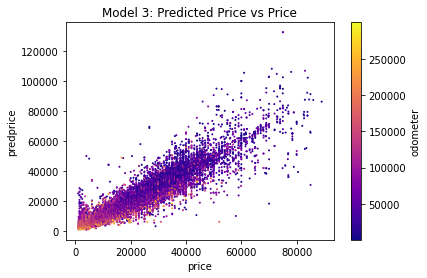

In [59]:
#Create a pandas dataframe for plotting
df = check.select("price", "predprice", "odometer").toPandas()

#Plot predprice vs price on a scatter graph
fig, ax = plt.subplots()
plt.title('Model 3: Predicted Price vs Price')
df.plot(kind="scatter", x="price", y="predprice", s=1, c="odometer", cmap="plasma", ax=ax)

A perfect model would be a perfectly straight line.  This model has quite a large spread in points.

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

## <font color='red'>4.5 Model 4 - Develop More Complex Model (maximising attributes) <a class="anchor" name="mod4"></a></font>


Model 4 is a model using all available attributes so removing null values.  This reduces the size of the dataset and increases model complexity.

### <font color='red'>4.5.1 Data Preparation <a class="anchor" name="mod4-dataprep"></a></font>


Need to first remove all the null values

In [60]:
mod4 = vehicles.select("pricelog", "year","year_scaled", "manufacturer","model","condition",\
                       "cylinders","fuel","odometer", "odometer_scaled", "transmission","drive","type","paint_color", "state")\
               .where(vehicles.condition.isNotNull())\
               .where(vehicles.cylinders.isNotNull())\
               .where(vehicles.drive.isNotNull())\
               .where(vehicles.paint_color.isNotNull())\

mod4.show(5)

+-----------------+----+--------------------+------------+--------------------+---------+---------+-----+--------+--------------------+------------+-----+------+-----------+-----+
|         pricelog|year|         year_scaled|manufacturer|               model|condition|cylinders| fuel|odometer|     odometer_scaled|transmission|drive|  type|paint_color|state|
+-----------------+----+--------------------+------------+--------------------+---------+---------+-----+--------+--------------------+------------+-----+------+-----------+-----+
|9.104424146384634|2013|[0.7391304347826086]|        FORD|        EXPLORER 4X4|     GOOD|        6|  GAS|150000.0|[0.4991652698849408]|   AUTOMATIC|  4WD|   SUV|     CUSTOM|   CT|
|10.65937476291726|2019|               [1.0]|   CHEVROLET|TAHOE LT SPORT UT...|     GOOD|        8|OTHER| 39513.0|[0.1302579649947579]|       OTHER|  4WD|   SUV|      BLACK|   CA|
|9.798071479779479|2009|[0.5652173913043478]|   CHEVROLET| SILVERADO 2500HD LT|EXCELLENT|        6| 

In [61]:
#check size of mod4 file
print((mod4.count(), len(mod4.columns)))

(80920, 15)


There are only 80920 rows left in the file after removal of all the null values.  This makes the dataset much smaller (removed approximately 63% of the dataset) while increasing model complexity.

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='red'>4.5.2 Train-Test Split <a class="anchor" name="mod4-train-test-split"></a></font>



In [62]:
#split the data into train and test and check number of rows
trainDF, testDF = mod4.randomSplit([.8, .2], seed=42)
print(f"""There are {trainDF.count()} rows in the training set, 
and {testDF.count()} in the test set""")


There are 64847 rows in the training set, 
and 16073 in the test set


<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='red'>4.5.3 Model Building <a class="anchor" name="mod4-model-building"></a></font>

First transform the data into a single vector using VectorAssembler which takes a list of input columns and creates a new dataframe with an additional column, called features.  VectorAssembler combines the values of those input columns into a single vector.

The categorical values need to be first mapped into numeric values by applying StringIndexer (which converts categorical values into category indexes) then pass these inputs to the OneHotEncoder which maps a column of category indices to a column of binary vectors.

In [63]:
#Define the categorical and numeric columns
categoricalCols = ['manufacturer', 'model', 'condition', 'fuel', 'transmission', 'drive', 'type', 'paint_color', 'state']
numericCols = ['year_scaled', 'odometer_scaled']

#Define column names for index output columns and ohe output
indexOutputCols = [x + "Index" for x in categoricalCols]
oheOutputCols = [x + "OHE" for x in categoricalCols]

#apply string indexer and ohe
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=indexOutputCols, handleInvalid="skip")
oheEncoder = OneHotEncoder(inputCols=indexOutputCols, outputCols=oheOutputCols)

#Define the vector assembler inputs (ohe and numeric columns)
assemblerInputs = oheOutputCols + numericCols

#Run the vector assembler
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

In order to apply our model to our test set, need to prepare the test data in the same way as the training set so setup the stages in a pipeline.

In [64]:
#Define the linear regression
lr = LinearRegression(labelCol="pricelog", featuresCol="features")

#build the pipeline
pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, lr])

#apply the pipeline to the training dataset
pipelineModel = pipeline.fit(trainDF)

#apply the pipeline to the test dataset
predDF = pipelineModel.transform(testDF)

#take a sample and look
predDF.select("features", "pricelog", "prediction").show(5)

+--------------------+-----------------+-----------------+
|            features|         pricelog|       prediction|
+--------------------+-----------------+-----------------+
|(7551,[3,62,7468,...|7.003065458786462|7.167600463771224|
|(7551,[5,49,7468,...|7.003065458786462|7.764130307417427|
|(7551,[22,139,746...|7.003065458786462| 8.08151274624944|
|(7551,[29,443,746...|7.003065458786462|8.557026001870327|
|(7551,[1,330,7466...|7.047517221357296|  8.8022587448126|
+--------------------+-----------------+-----------------+
only showing top 5 rows



The features column is represented as a SparseVector. There are 7551 features after one-hot encoding, followed by the nonzero indices and then the values
themselves.

In [65]:
#Take a look at the other columns
predDF.select("year", "manufacturer", "model", "fuel", "odometer", "transmission", "type", "state", "pricelog", "prediction").show(10)

+----+------------+--------------+----+--------+------------+--------+-----+-----------------+------------------+
|year|manufacturer|         model|fuel|odometer|transmission|    type|state|         pricelog|        prediction|
+----+------------+--------------+----+--------+------------+--------+-----+-----------------+------------------+
|1997|       HONDA|       ODYSSEY| GAS|217005.0|   AUTOMATIC|MINI-VAN|   AZ|7.003065458786462| 7.167600463771224|
|2002|        JEEP|GRAND CHEROKEE| GAS|198000.0|   AUTOMATIC|     SUV|   VA|7.003065458786462| 7.764130307417427|
|2003|       ACURA|            TL| GAS|220000.0|   AUTOMATIC|   SEDAN|   FL|7.003065458786462|  8.08151274624944|
|2008|      SATURN|          AURA| GAS|126000.0|   AUTOMATIC|   SEDAN|   NY|7.003065458786462| 8.557026001870327|
|2013|   CHEVROLET|      SONIC LT| GAS| 83000.0|      MANUAL|   SEDAN|   ID|7.047517221357296|   8.8022587448126|
|2013|         KIA|       SORENTO| GAS|181578.0|   AUTOMATIC|     SUV|   OH|7.0859014643

To compare actual price instead of log price convert back to real price

In [66]:
check = predDF.withColumn("price", exp("pricelog")).withColumn("predprice", exp("prediction"))
check.select("year", "manufacturer", "model", "fuel", "odometer", "transmission", "type", "state", round("price"), round("predprice")).show(20)


+----+------------+----------------+------+--------+------------+---------+-----+---------------+-------------------+
|year|manufacturer|           model|  fuel|odometer|transmission|     type|state|round(price, 0)|round(predprice, 0)|
+----+------------+----------------+------+--------+------------+---------+-----+---------------+-------------------+
|1997|       HONDA|         ODYSSEY|   GAS|217005.0|   AUTOMATIC| MINI-VAN|   AZ|         1100.0|             1297.0|
|2002|        JEEP|  GRAND CHEROKEE|   GAS|198000.0|   AUTOMATIC|      SUV|   VA|         1100.0|             2355.0|
|2003|       ACURA|              TL|   GAS|220000.0|   AUTOMATIC|    SEDAN|   FL|         1100.0|             3234.0|
|2008|      SATURN|            AURA|   GAS|126000.0|   AUTOMATIC|    SEDAN|   NY|         1100.0|             5203.0|
|2013|   CHEVROLET|        SONIC LT|   GAS| 83000.0|      MANUAL|    SEDAN|   ID|         1150.0|             6649.0|
|2013|         KIA|         SORENTO|   GAS|181578.0|   A

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='red'>4.5.4 Evaluation <a class="anchor" name="mod4-evaluation"></a></font>

Root Mean Square Error (RMSE) and R squared (R2) will be used to evaluate the model performance

#### <font color='red'>4.5.4.1 Root Mean Square Error (RMSE) <a class="anchor" name="mod4-rmse"></a></font>



RMSE is a metric that ranges from zero to infinity.  The closer it is to zero the better.


In [67]:
#Evaluate the model using RMSE
regressionEvaluator = RegressionEvaluator(
 predictionCol="prediction",
 labelCol="pricelog",
 metricName="rmse")
mod4rmse = regressionEvaluator.evaluate(predDF)
print(f"Model 4 RMSE is {mod4rmse:.5f}")
print("compare this with...")
print(f"Model 1 RMSE is {mod1rmse:.5f}")
print(f"Model 2 RMSE is {mod2rmse:.5f}")
print(f"Model 3 RMSE is {mod3rmse:.5f}")


Model 4 RMSE is 0.27389
compare this with...
Model 1 RMSE is 0.44037
Model 2 RMSE is 0.44037
Model 3 RMSE is 0.24300


Compare against baseline RMSE

In [68]:
#compute the average pricelog for the training dataset
mod4avg = trainDF.select(avg("pricelog")).collect()[0][0]
print(mod4avg)


9.300318513530577


Calculate the training and test RMSE of our baseline model.

In [69]:
#First convert Pyspark dataframes to RDDs
trainrdd=trainDF.rdd
testrdd=testDF.rdd

#create RDDs of (label, prediction) tuples for training dataset
labelsAndPredsTrain = trainrdd.map(lambda x: (x.pricelog, mod4avg))
#call calcRMSE
rmseTrainBase = calcRMSE(labelsAndPredsTrain)

#create RDDs of (label, prediction) tuples for test dataset
labelsAndPredsTest = testrdd.map(lambda x: (x.pricelog, mod4avg))
##call calcRMSE
rmseTestBase = calcRMSE(labelsAndPredsTest)

print('Baseline Train RMSE = {0:.5f}'.format(rmseTrainBase))
print('Baseline Test RMSE = {0:.5f}'.format(rmseTestBase))
print("Compare this with..")
print(f"Model 4 RMSE = {mod4rmse:.5f}")

Baseline Train RMSE = 0.81576
Baseline Test RMSE = 0.81007
Compare this with..
Model 4 RMSE = 0.27389


Our model (RSME = 0.273) beat the baseline of 0.816 so yay!

#### <font color='red'>4.4.4.2 R Squared Error (R2) <a class="anchor" name="mod4-r2"></a></font>


Another option for evaluating the model is to use R2.

In [70]:
# Calculate R2
mod4r2 = regressionEvaluator.setMetricName("r2").evaluate(predDF)
print(f"Model 4 R2 is {mod4r2:.5f}")
print("Compare this with..")
print(f"Model 1 R2 is {mod1r2:.5f}")
print(f"Model 2 R2 is {mod2r2:.5f}")
print(f"Model 3 R2 is {mod3r2:.5f}")


Model 4 R2 is 0.88584
Compare this with..
Model 1 R2 is 0.66890
Model 2 R2 is 0.66890
Model 3 R2 is 0.89877


If the model perfectly predicts every point it would have an R2 values of 1 and a model that is not performing well has a value closer to 0.

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

#### <font color='red'>4.4.4.3 Plot results<a class="anchor" name="mod4-plot"></a></font>

<AxesSubplot:title={'center':'Model 4: Predicted Price vs Price'}, xlabel='price', ylabel='predprice'>

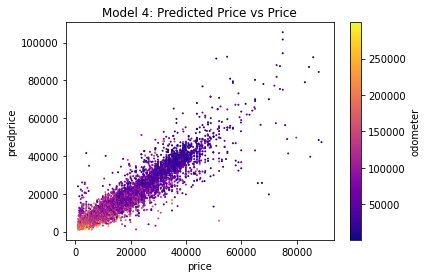

In [71]:
#Create a pandas dataframe for plotting
df = check.select("price", "predprice", "odometer").toPandas()

#Plot predprice vs price on a scatter graph
fig, ax = plt.subplots()
plt.title('Model 4: Predicted Price vs Price')
df.plot(kind="scatter", x="price", y="predprice", s=1, c="odometer", cmap="plasma", ax=ax)

A perfect model would be a perfectly straight line.  This model has quite a large spread in points.

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

## <font color='black'>4.6 Best Model Selection <a class="anchor" name="best-mod"></a></font>

In [72]:
#Comparing the Models
print(f"Model 1 R2 is {mod1r2:} and RMSE is {mod1rmse:}")
print(f"Model 2 R2 is {mod2r2:} and RMSE is {mod2rmse:}")
print(f"Model 3 R2 is {mod3r2:} and RMSE is {mod3rmse:}")
print(f"Model 4 R2 is {mod4r2:} and RMSE is {mod4rmse:}")

Model 1 R2 is 0.6688983451523918 and RMSE is 0.44036848042461896
Model 2 R2 is 0.6688983451529625 and RMSE is 0.4403684804242393
Model 3 R2 is 0.8987680950241743 and RMSE is 0.24300282068598134
Model 4 R2 is 0.8858355341002995 and RMSE is 0.27389459105833386


The best model is Model 3 which has the highest R2 and the lowest RMSE values.  Hyperparameter tuning will be conducted on this model in the next section

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='black'>4.6.1 Setup the Model <a class="anchor" name="best-mod-setup"></a></font>

Setup model 3

In [73]:
#split the data into train and test and check number of rows
trainDF, testDF = mod3.randomSplit([.8, .2], seed=42)

#Define the categorical and numeric columns
categoricalCols = ['manufacturer', 'model', 'fuel', 'transmission', 'type', 'state']
numericCols = ['year_scaled', 'odometer_scaled']

#Define column names for index output columns and ohe output
indexOutputCols = [x + "Index" for x in categoricalCols]
oheOutputCols = [x + "OHE" for x in categoricalCols]

#apply string indexer and ohe
stringIndexer = StringIndexer(inputCols=categoricalCols, outputCols=indexOutputCols, handleInvalid="skip")
oheEncoder = OneHotEncoder(inputCols=indexOutputCols, outputCols=oheOutputCols)

#Define the vector assembler inputs (ohe and numeric columns)
assemblerInputs = oheOutputCols + numericCols

#Run the vector assembler
vecAssembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

#Define the linear regression
lr = LinearRegression(labelCol="pricelog", featuresCol="features")

#build the pipeline
pipeline = Pipeline(stages = [stringIndexer, oheEncoder, vecAssembler, lr])

#apply the pipeline to the training dataset
pipelineModel = pipeline.fit(trainDF)

#apply the pipeline to the test dataset
predDF = pipelineModel.transform(testDF)

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='black'>4.6.2 Cross Validation & Hyperparameter Tuning <a class="anchor" name="bestmod-crossval"></a></font>

In a linear model with many predictor variables or if these variables are correlated, the standard Ordinary Least Squares parameter estimates have large variance, thus making the model unreliable.  In order to counter this you can use use regularization - a technique which decreases the variance at the cost of introducing some bias. Finding a good bias-variance trade-off minimizes model's total error.

There are three popular regularization techniques, each of them aiming at decreasing the size of the coefficients:
Ridge Regression, which penalizes sum of squared coefficients (L2 penalty).
Lasso Regression, which penalizes the sum of absolute values of the coefficients (L1 penalty).
Elastic Net, a convex combination of Ridge and Lasso.

The hyperparameters to be tuned to check for this include regParam and eleasticNetParam

First take a look at a list of default parameters for the model 3 estimater. 

In [74]:
#Check default parameters of model
pipelineModel.stages[-1].extractParamMap()

{Param(parent='LinearRegression_ed8743769ee8', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2,
 Param(parent='LinearRegression_ed8743769ee8', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0,
 Param(parent='LinearRegression_ed8743769ee8', name='featuresCol', doc='features column name.'): 'features',
 Param(parent='LinearRegression_ed8743769ee8', name='fitIntercept', doc='whether to fit an intercept term.'): True,
 Param(parent='LinearRegression_ed8743769ee8', name='labelCol', doc='label column name.'): 'pricelog',
 Param(parent='LinearRegression_ed8743769ee8', name='predictionCol', doc='prediction column name.'): 'prediction',
 Param(parent='LinearRegression_ed8743769ee8', name='solver', doc='The solver algorithm for optimization. Supported options: auto, normal, l-bfgs.'): 'auto',
 Param(parent='LinearRegression_ed8743769ee8', name='standa

Check how many coefficients in this model

In [75]:
coeff = pipelineModel.stages[-1].coefficients
print("There are {} coefficients".format(len(coeff)))

There are 12258 coefficients


Setup a grid specifying all the parameters and the values to test on the model.  Assign a series of values for the hyperparameters <code>regParam</code> and <code>elasticNetParam</code>

Also specify 3 folds to test against.

In [76]:
#Build a grid specifiying the parameters to test
paramGrid = ParamGridBuilder().addGrid(lr.regParam, [0, 0.01, 0.1, 1]).addGrid(lr.elasticNetParam, [0, 0.5, 1]).build()

# Define an evaluator to be used for evaluating the model 
evaluator = RegressionEvaluator(labelCol="pricelog", predictionCol="prediction", metricName="rmse")

#Declare the CrossValidator using 3 folds
cv = CrossValidator(estimator=pipeline, evaluator=evaluator, estimatorParamMaps=paramGrid, numFolds=3, seed=42)

Next step is to train the cross-validator.  As the cross validator trains/evaluates the model for every fold of data across all possible parameter combinations, <strong style="color:red">this step is very expensive and might take some time to finsh!</strong>

In [77]:
#train the cross-validator
cvModel = cv.fit(trainDF)

In [78]:
#show a list of all the tests done
list(zip(cvModel.getEstimatorParamMaps(), cvModel.avgMetrics))

[({Param(parent='LinearRegression_ed8743769ee8', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LinearRegression_ed8743769ee8', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0},
  0.25140857103586645),
 ({Param(parent='LinearRegression_ed8743769ee8', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LinearRegression_ed8743769ee8', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5},
  0.25140857103586645),
 ({Param(parent='LinearRegression_ed8743769ee8', name='regParam', doc='regularization parameter (>= 0).'): 0.0,
   Param(parent='LinearRegression_ed8743769ee8', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alp

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='black'>4.6.3 Choosing the Best Model <a class="anchor" name="bestmod-choose"></a></font>

After running the CrossValidator, obtain the model with the best combination of hyperparameters using <code>.bestModel</code>. Also <code>bestModel.stages[-1]._java_obj.paramMap()</code> gives the hyperparameteres with the optimum values selected by the Cross Validator.

In [79]:
#Getting the best model and the optimum parameters selected from the Cross Validation 
bestModel= cvModel.bestModel
print("STAGES")
print(bestModel.stages)
print('Best Parameters: ', bestModel.stages[-1]._java_obj.paramMap())

STAGES
[StringIndexerModel: uid=StringIndexer_b5cefe87fb02, handleInvalid=skip, numInputCols=6, numOutputCols=6, OneHotEncoderModel: uid=OneHotEncoder_94f07ca4e683, dropLast=true, handleInvalid=error, numInputCols=6, numOutputCols=6, VectorAssembler_70bc7d619dbd, LinearRegressionModel: uid=LinearRegression_ed8743769ee8, numFeatures=12258]
Best Parameters:  {
	LinearRegression_ed8743769ee8-elasticNetParam: 0.0,
	LinearRegression_ed8743769ee8-featuresCol: features,
	LinearRegression_ed8743769ee8-labelCol: pricelog,
	LinearRegression_ed8743769ee8-regParam: 0.0
}


The best model from our CrossValidator has regParam = 0.0 and elasticNetParam = 0.0

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

### <font color='black'>4.6.4 Making Predictions <a class="anchor" name="bestmod-pred"></a></font>        
        

Transform the test dataset using the best model and take a look at the price and predicted price columns.

In [80]:
#Transform the test dataset using the best model
predDF = bestModel.transform(testDF)

#Transform price values from log back to normal price
check = predDF.withColumn("price", exp("pricelog")).withColumn("predprice", exp("prediction"))

#Take a look at the final dataframe with attributes, price and predicted price.
check.select("year", "manufacturer", "model", "fuel", "odometer", "transmission", "type", "state", round("price"), round("predprice")).show(20)


+----+------------+----------------+----+--------+------------+---------+-----+---------------+-------------------+
|year|manufacturer|           model|fuel|odometer|transmission|     type|state|round(price, 0)|round(predprice, 0)|
+----+------------+----------------+----+--------+------------+---------+-----+---------------+-------------------+
|1997|       HONDA|         ODYSSEY| GAS|217005.0|   AUTOMATIC| MINI-VAN|   AZ|         1100.0|             2133.0|
|1999|        AUDI|              A4| GAS|195000.0|      MANUAL|    SEDAN|   FL|         1100.0|             2607.0|
|2002|      NISSAN|          MAXIMA| GAS|181180.0|   AUTOMATIC|    SEDAN|   MD|         1100.0|             2953.0|
|2003|   CHEVROLET|         VENTURE| GAS|234000.0|   AUTOMATIC| MINI-VAN|   OH|         1100.0|             2053.0|
|2004|  MITSUBISHI|          LANCER| GAS|170000.0|   AUTOMATIC|    SEDAN|   OH|         1100.0|             3002.0|
|2008|      SATURN|            AURA| GAS|126000.0|   AUTOMATIC|    SEDAN

Plot predicted price vs price on a scatter plot to see how it performed.  Use odometer as a color scale.

<AxesSubplot:title={'center':'Best Model: Predicted Price vs Price'}, xlabel='price', ylabel='predprice'>

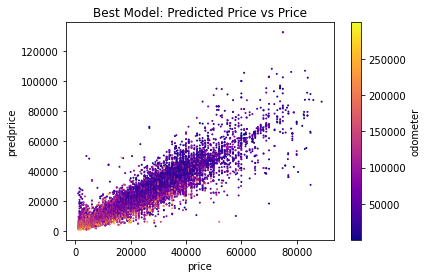

In [81]:
#Create a pandas dataframe for plotting
df = check.select("price", "predprice", "odometer").toPandas()

#Plot predprice vs price on a scatter graph
fig, ax = plt.subplots()
plt.title('Best Model: Predicted Price vs Price')
df.plot(kind="scatter", x="price", y="predprice", s=1, c="odometer", cmap="plasma", ax=ax)

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

# <font color='black'>5. Conclusion <a class="anchor" name="conclusion"></a></font>

Four linear regression models were setup to test how well used car price could be predicted from the given dataset.
- Model 1 was a simple regression model using only year, manufacturer and odometer. 
- Model 2 was a simple regression model using scaled numeric values year_scaled, manufacturer and odometer_scaled.
- Model 3 was a more complex model using all of the attributes that did not have null values
- Model 4 was a more complex model using all of the available attributes and removing records with null values.
 
The best of these models was Model 3 and hyperparameter tuning was conducted on this model
The optimum hyperparameters were regParam = 0 and elasticNetParam = 0

<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>

# 6. References <a class="anchor" name="references"></a>


Apache Spark. (2021). Linear Methods - ML - Spark 1.5.2 Documentation. Retrieved June 1, 2021, from Spark.apache.org: https://spark.apache.org/docs/1.5.2/ml-linear-methods.html

databricks. (n.d.). W6L1: Linear Regression Lab. Retrieved June 1, 2021, from https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/1779476228152266/1437143569842664/5673666086694627/latest.html

Oleszak, M. (2019, Nov 13). datacamp. Retrieved June 2, 2021, from Regularization: Ridge, Lasso and Elastic Net: https://www.datacamp.com/community/tutorials/tutorial-ridge-lasso-elastic-net

Reese, A. (2021, May 4). Used Cars Dataset - Vehicles listings from Craigslist.org. Retrieved May 17, 2021, from Kaggle.com: https://www.kaggle.com/austinreese/craigslist-carstrucks-data




<font color=black>Return to 
[Table of Contents](#table-of-contents)</font>